Prediction of the BTC volatility using LSTM.

In [2]:
from datetime import datetime

import jax
import yfinance as yf
from flax import nnx
import jax.numpy as jnp
import pandas as pd
import tqdm


<h1> BTC Volatility Prediction using LSTM</h1>
<p> In this notebook we will predict the volatility of BTC using an ML model based on LSTM. The model will be trained using
FLAX NNX a new neural network library for JAX. FLAX NNX is also used in ie Gemma 3 or Imagen by Google</p>

In [43]:
# First we need to define some Hyperparameters so that we can change them easily
VOLATILITY_WINDOW = 30  # Window size for calculating volatility in days
TIMESERIES_LENGTH = 60  # Length of the time series to use for training
BATCH_SIZE = 32  # Batch size for training
EPOCHS = 10  # Number of epochs to train the model

SHOW_DEBUG_INFO = True  # Whether to show debug information during training



Lets first download the data.

In [4]:
import os

def download_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Download historical data for a given ticker."""
    # check if the data is already downloaded
    if f"{ticker}_data.csv" in os.listdir():
        print(f"Data for {ticker} already downloaded.")
        dataframe = pd.read_csv(f"{ticker}_data.csv", index_col=0, parse_dates=True, date_format="%Y-%m-%d")
        # remove first two rows as they are not needed
        dataframe = dataframe.iloc[2:]
        # interpret all but the first column as float
        for col in dataframe.columns[1:]:
            dataframe[col] = pd.to_numeric(dataframe[col], errors='raise')
        dataframe['Close'] = pd.to_numeric(dataframe['Close'], errors='raise')
        return dataframe


    data = yf.download(ticker, start=start, end=end)
    # save the data to a CSV file
    data.to_csv(f"{ticker}_data.csv")

    return data


btc = download_data('BTC-USD', start='2015-01-01', end='2023-10-01')
#btc = yf.download('BTC-USD', start='2015-01-01', end='2023-10-01')
if SHOW_DEBUG_INFO:
    print(f"Downloaded {len(btc)} rows of data for BTC-USD")
    print(f"Columns: {btc.columns.tolist()}")
    print(f"Data types:\n{btc.dtypes}")
    btc.info()

Data for BTC-USD already downloaded.
Downloaded 3195 rows of data for BTC-USD
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3195 entries, 2015-01-01 to 2023-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3195 non-null   float64
 1   High    3195 non-null   float64
 2   Low     3195 non-null   float64
 3   Open    3195 non-null   float64
 4   Volume  3195 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 149.8+ KB


In [5]:
def calculate_daily_volatility(data: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    data['Returns'] = data['Close'].pct_change()
    data['Annualized_Volatility'] = data['Returns'].rolling(window=window).std() * (252 ** 0.5)  # Annualize the volatility
    return data

btc = calculate_daily_volatility(btc)
if SHOW_DEBUG_INFO:
    print(f"Calculated daily volatility for BTC-USD with a window of {VOLATILITY_WINDOW} days")
    print(f"Data after calculating volatility:\n{btc.head()}")
    print(f"Data types after calculating volatility:\n{btc.dtypes}")

Calculated daily volatility for BTC-USD with a window of 30 days
Data after calculating volatility:
                 Close        High         Low        Open    Volume  \
Price                                                                  
2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550   
2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650   
2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400   
2015-01-04  264.195007  287.230011  257.612000  281.145996  55629100   
2015-01-05  274.473999  278.341003  265.084015  265.084015  43962800   

             Returns  Annualized_Volatility  
Price                                        
2015-01-01       NaN                    NaN  
2015-01-02  0.002492                    NaN  
2015-01-03 -0.107767                    NaN  
2015-01-04 -0.060079                    NaN  
2015-01-05  0.038907                    NaN  
Data types after calculating volatility:
Close                    float64

In [33]:
# preprocessing the data
def scale_dataframe_minus_one_to_one(df: pd.DataFrame, columns_to_scale: list[str]) -> pd.DataFrame:
    """
    Scales all numeric columns in a Pandas DataFrame to the range [-1, 1].

    Args:
        df: The input Pandas DataFrame.

    Returns:
        A new Pandas DataFrame with numeric columns scaled to [-1, 1].
        Non-numeric columns are returned unchanged.
        :param df: The Dataframe to scale.
        :param columns_to_scale: A list of column names to scale. If empty, no column will be scaled.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_scaled = df.copy()

    # Iterate over each column in the DataFrame
    for column in df_scaled.columns:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df_scaled[column]) and column in columns_to_scale:
            min_val = df_scaled[column].min()
            max_val = df_scaled[column].max()

            # Check if min_val and max_val are the same to avoid division by zero
            if min_val == max_val:
                # If all values are the same, scale them to 0
                # (or you could choose -1 or 1, but 0 is neutral)
                df_scaled[column] = 0.0
            else:
                # Apply the scaling formula: 2 * (x - min) / (max - min) - 1
                df_scaled[column] = 2 * (df_scaled[column] - min_val) / (max_val - min_val) - 1
        else:
            # If column is not numeric, print a warning and leave it as is
            print(f"Warning: Column '{column}' is not numeric or not in the list to scale and will not be scaled.")

    return df_scaled

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    # To Test the targe will be the index in of the next row
    data['Target'] = data['Annualized_Volatility'].shift(-1)  # Shift the target by one row
    # Drop the last row as it will have NaN target
    data = data.dropna()
    # Select relevant features
    features = ['Annualized_Volatility','Open', 'Close', 'Volume']# ['Open', 'High', 'Low', 'Close', 'Volume'] # ggf add annualized volatility

    # scale the features between -1 and 1
    data = scale_dataframe_minus_one_to_one(data, features)

    return data[features + ['Target']]


if SHOW_DEBUG_INFO:
    print("Preprocessing data...")
    print(f"Data after preprocessing:\n{preprocess_data(btc).head(100)}")

Preprocessing data...
Data after preprocessing:
            Annualized_Volatility      Open     Close    Volume    Target
Price                                                                    
2015-01-31               0.611267 -0.999514 -0.999793 -0.999927  1.199454
2015-02-01               0.625526 -0.999798 -0.999511 -0.999894  1.172109
2015-02-02               0.584628 -0.999512 -0.999176 -0.999886  1.166827
2015-02-03               0.576728 -0.999187 -0.999502 -0.999828  1.160287
2015-02-04               0.566945 -0.999482 -0.999514 -0.999909  1.157118
...                           ...       ...       ...       ...       ...
2015-05-06              -0.595789 -0.999222 -0.999427 -0.999892  0.396399
2015-05-07              -0.575574 -0.999418 -0.999203 -0.999895  0.394430
2015-05-08              -0.578518 -0.999194 -0.999009 -0.999904  0.394868
2015-05-09              -0.577864 -0.998999 -0.999070 -0.999948  0.384202
2015-05-10              -0.593817 -0.999060 -0.999115 -0.999975 

Now let's create a simple LSTM model to predict the volatility...

In [27]:

class LSTM(nnx.Module):
    features: int

    def __init__(self, features: int, hidden_features: int, *, rngs: jax.random.PRNGKey):
        self.rngs, initial_rngs = jax.random.split(rngs)
        self.rngs, initial_linear_rngs = jax.random.split(self.rngs)

        self.features = features
        self.hidden_size = hidden_features

        self.lstm_cell = nnx.LSTMCell(
            features,  # Number of features in the input
            hidden_features,  # Size of the hidden state
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
        self.lstm_layer = nnx.RNN(
            self.lstm_cell,  # The LSTM cell to use
            return_carry=False,
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
        self.intermediate_linear = nnx.Linear(
            hidden_features,  # Number of input features
            hidden_features // 2,  # Number of output features
            rngs=nnx.Rngs(initial_linear_rngs)  # Random number generator for initialization
        )  # Linear layer to transform input features
        self.half_lstm_cell = nnx.LSTMCell(
            hidden_features // 2,  # Number of features in the input
            hidden_features // 2,  # Size of the hidden state
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
        self.half_lstm_layer = nnx.RNN(
            self.half_lstm_cell,  # The LSTM cell to use
            return_carry=False,
            rngs=nnx.Rngs(initial_rngs)  # Random number generator for initialization
        )
     #   self.linear_test = nnx.Linear(features, self.hidden_size, rngs=nnx.Rngs(initial_rngs))  # Linear layer to transform input features
        self.linear = nnx.Linear(hidden_features // 2, 1, rngs=nnx.Rngs(initial_linear_rngs))
        # Linear layer to output the prediction


    def __call__(self, x):
        """Forward pass of the LSTM model."""
        y_full = self.lstm_layer(x)  # Pass the input through the LSTM layer
        intermediate_y = self.intermediate_linear(y_full)  # Pass through the intermediate linear layer
        y_half = self.half_lstm_layer(intermediate_y)  # Pass the input through the half LSTM layer
        last_layer_output = y_half[:, -1, :]
        # Get the last output of the LSTM
        #last_layer_output = self.linear_test(x)
        y = self.linear(last_layer_output)  # Pass through the
        return y

    def initial_state(self, batch_size: int):
        return jnp.zeros((batch_size, self.hidden_size))


if SHOW_DEBUG_INFO:
    model = LSTM(features=1, hidden_features=256, rngs=jax.random.PRNGKey(0))  # 6 features: Open, High, Low, Close, Volume
    nnx.display(model)


In [8]:
import optax


# Alright, now lets define some helper functions
def compute_metrics(predictions: jnp.ndarray, targets: jnp.ndarray) -> dict:
    """Compute metrics for the model predictions."""
    mse = jnp.mean((predictions - targets) ** 2)
    mae = jnp.mean(jnp.abs(predictions - targets))
    return {'mse': mse, 'mae': mae}

def create_training_state(rng: nnx.Rngs) -> tuple[nnx.Module, optax.GradientTransformation]:
    """Create a training state for the model."""
    lstm = LSTM(features=6, rngs=rng)
    tx = optax.adam(1e-3)
    return lstm, tx

def loss_fn(model: LSTM, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    y_pred = model(x)
    return jnp.mean((y_pred - y) ** 2)

@nnx.jit
def train_step(model, optimizer, x, y):
  grad_fn = nnx.value_and_grad(loss_fn)
  loss, grads = grad_fn(model, x, y)
  optimizer.update(grads)  # In place updates.
  return loss

def transform_data_to_training_timeseries(data: pd.DataFrame, window_size: int = 100) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Transform the DataFrame into a time series format for training."""
    # Convert DataFrame to JAX array
    y = jnp.array(data['Target'])
    x_unformatted = jnp.array(data.drop(columns=['Target']))
    x = jnp.array([x_unformatted[i:i + window_size] for i in range(len(x_unformatted) - window_size)])
    y = y[window_size:] # drop label for series that are not complete
    return x, y

def train_test_split(data: pd.DataFrame, test_size: float = 0.2) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into training and testing sets."""
    split_index = int(len(data) * (1 - test_size))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data


In [44]:
# Now we can run the training loop
from sklearn.utils import shuffle

def train_model(model, optimizer, X_train: jnp.ndarray, Y_train: jnp.ndarray, epochs: int = 10, batch_size: int = 32):
    """Train the LSTM model."""
    for epoch in range(epochs):
        for i in tqdm.tqdm(range(0, len(X_train), batch_size)):
            x_batch: jnp.array = X_train[i:i + batch_size]
            y_batch: jnp.array = Y_train[i:i + batch_size]
            loss = train_step(model, optimizer, x_batch, y_batch)
        print(f"Epoch {epoch + 1}, Loss: {loss:.8f}")



lstm = LSTM(features=4,hidden_features=256, rngs=jax.random.PRNGKey(0))
optimizer = nnx.Optimizer(lstm, optax.adam(1e-3))  # Using Adam optimizer
pre_data = preprocess_data(btc)
# Split the data into training and testing sets
train_data, test_data = train_test_split(pre_data, test_size=0.2)
X_train, y_train = transform_data_to_training_timeseries(train_data, window_size=TIMESERIES_LENGTH)
# shuffle the timeseries data
shuffled_X_train, shuffled_y_train = shuffle(X_train, y_train, random_state=42)

train_model(lstm, optimizer, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

  0%|          | 0/78 [00:00<?, ?it/s]

(32, 60, 128)


 97%|█████████▋| 76/78 [00:05<00:00, 13.62it/s]

(7, 60, 128)


100%|██████████| 78/78 [00:06<00:00, 11.98it/s]


Epoch 1, Loss: 0.00482967


100%|██████████| 78/78 [00:04<00:00, 16.03it/s]


Epoch 2, Loss: 0.00315385


100%|██████████| 78/78 [00:04<00:00, 15.92it/s]


Epoch 3, Loss: 0.03076251


100%|██████████| 78/78 [00:04<00:00, 15.65it/s]


Epoch 4, Loss: 0.01027312


100%|██████████| 78/78 [00:04<00:00, 16.09it/s]


Epoch 5, Loss: 0.00249494


100%|██████████| 78/78 [00:05<00:00, 15.42it/s]


Epoch 6, Loss: 0.00245017


100%|██████████| 78/78 [00:04<00:00, 15.82it/s]


Epoch 7, Loss: 0.00311273


100%|██████████| 78/78 [00:05<00:00, 15.47it/s]


Epoch 8, Loss: 0.00297566


100%|██████████| 78/78 [00:05<00:00, 14.40it/s]


Epoch 9, Loss: 0.00292816


100%|██████████| 78/78 [00:05<00:00, 14.46it/s]


Epoch 10, Loss: 0.00299758


Test data shape: (333, 300, 4), Target shape: (333,)
(333, 300, 128)
{'mse': Array(0.03481257, dtype=float32), 'mae': Array(0.15530102, dtype=float32)}


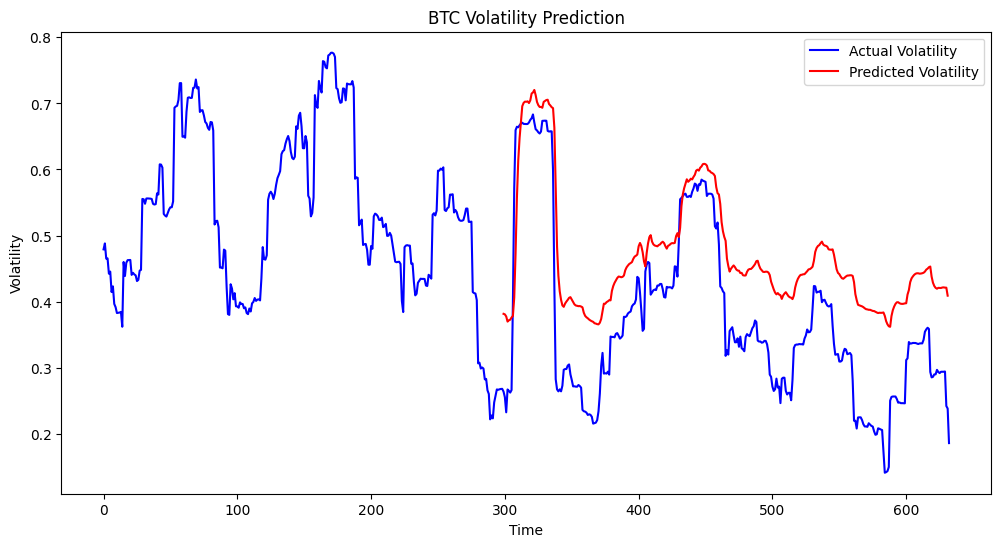

In [42]:
# Now we can evaluate the model on the test set
def evaluate_model(model: LSTM, data: pd.DataFrame):
    """Evaluate the model on the test set."""
    # First, transform the test data into the same format as the training data
    x, y = transform_data_to_training_timeseries(data, window_size=TIMESERIES_LENGTH)
    print(f"Test data shape: {x.shape}, Target shape: {y.shape}")
    prediction = model(x)
    metrics = compute_metrics(prediction, y)

    # add TIMESERIES_LENGTH - 1 to the start of the prediction to align it with the target
    prediction = jnp.concatenate([jnp.full((TIMESERIES_LENGTH -1, 1), jnp.nan), prediction], axis=0)
    return metrics, prediction

# plot the predictions against the actual values
import matplotlib.pyplot as plt
def plot_predictions(predictions: jnp.ndarray, targets: jnp.ndarray):
    """Plot the predictions against the actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(targets, label='Actual Volatility', color='blue')
    plt.plot(predictions, label='Predicted Volatility', color='red')
    plt.title('BTC Volatility Prediction')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()


# Evaluate the model on the test set
metrics, predictions = evaluate_model(lstm, test_data)
# get the last element of every series in predictions
  # Get the last element of each series
print(metrics)
plot_predictions(predictions, test_data['Target'].to_numpy())